In [1]:
from functions_ngates_v1 import calc_variance_ng, calc_variance_pure, calc_variance_ng_crx_batched
from functions_ngates_v0 import calc_variance
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import cProfile
from tqdm.notebook import tqdm

In [2]:
cProfile.run('calc_variance_ng_crx_batched(4, 5, theta=np.pi/2, device="cpu", n_sim=100, n_sim_noise=1)')

         24720 function calls in 0.261 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.261    0.261 <string>:1(<module>)
      100    0.000    0.000    0.001    0.000 _tensor.py:1071(__rsub__)
      100    0.000    0.000    0.001    0.000 _tensor.py:33(wrapped)
      500    0.046    0.000    0.075    0.000 functions_ngates_v1.py:188(build_crx_layer_operator_batch)
      500    0.002    0.000    0.009    0.000 functions_ngates_v1.py:198(<listcomp>)
      500    0.019    0.000    0.153    0.000 functions_ngates_v1.py:22(global_rotation)
        1    0.024    0.024    0.261    0.261 functions_ngates_v1.py:230(calc_variance_ng_crx_batched)
     2000    0.102    0.000    0.123    0.000 functions_ngates_v1.py:7(U3_rotation)
        1    0.000    0.000    0.002    0.002 functions_ngates_v1.py:75(generate_H)
        1    0.000    0.000    0.000    0.000 functions_ngates_v1.py:83(<listcomp>)
        

In [3]:
a = calc_variance_ng_crx_batched(4, 5, theta=np.pi/2, device='cpu', n_sim=10, n_sim_noise=500)
a.shape

torch.Size([10, 500])

In [8]:
a[:,-1]

tensor([-6.7913, -1.3286,  7.5714, -1.2269, 10.8315, -1.0655,  4.5320, -0.4887,
         0.0749,  2.6803], dtype=torch.float64)

In [3]:
N = 6
layers1 = np.arange(2, 25, 2)

In [7]:
result2 = [calc_variance_ng_crx_batched(N, l, theta=np.pi/2, device='cpu', n_sim=1000, n_sim_noise=1) for l in tqdm(layers1)]
result1 = [calc_variance_pure(N, l, theta=np.pi/2, device='cpu', n_sim=1000) for l in tqdm(layers1)]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
var1 = []
var2 = []
var0 = []

for l in range(len(layers1)):
    var1.append(th.std(result1[l]))
    var2.append(th.std(th.mean(result2[l], dim=1)))
    var0.append(th.std(result2[l][:,0]))

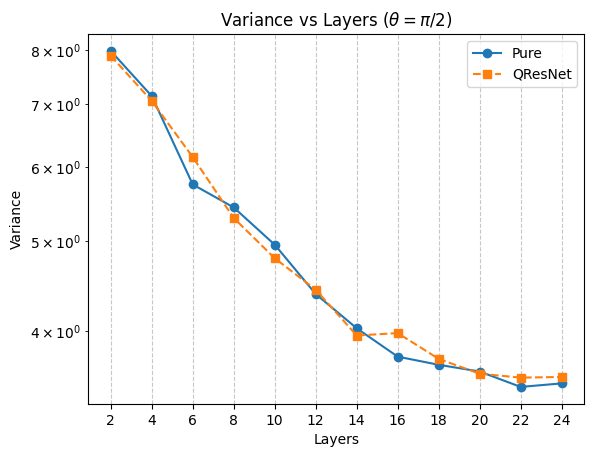

In [10]:
plt.semilogy(layers1, var1, marker='o', label='Pure')
#plt.semilogy(layers1, var2, marker='^', label='Lower bound')
plt.semilogy(layers1, var0, marker='s', label='QResNet', linestyle='--')
plt.xlabel('Layers')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.7)
plt.xticks(layers1)
plt.ylabel('Variance')
plt.title(r'Variance vs Layers ($\theta=\pi/2$)')
plt.legend()
plt.show()

In [5]:
n_qubits = np.arange(2,12,2)

In [ ]:
result1 = [calc_variance_pure(n, 20, theta=np.pi/2, device='cpu', n_sim=100)[:,-1] for n in tqdm(n_qubits)]

In [ ]:
result2 = []
for n in tqdm(n_qubits):
    
    jumpOPs = th.empty(n-1, 2**n, 2**n, dtype=th.complex128, device='cpu')
    for i in range(0,n-1):
        jumpOPs[i] = th.kron(th.eye(2**i), th.kron(generator, th.eye(2**(n-i-2))))
        
    result2.append(calc_variance_ng(n, 20, noise=(jumpOPs,True), theta=np.pi/2, device='cpu',n_sim=100, n_sim_noise=1)[:,:,-1])

In [9]:
var1 = []
var2 = []
var0 = []

for l in range(len(n_qubits)):
    var1.append(th.std(result1[l]))
    var2.append(th.std(th.mean(result2[l], dim=1)))
    var0.append(th.std(result2[l][:,0]))

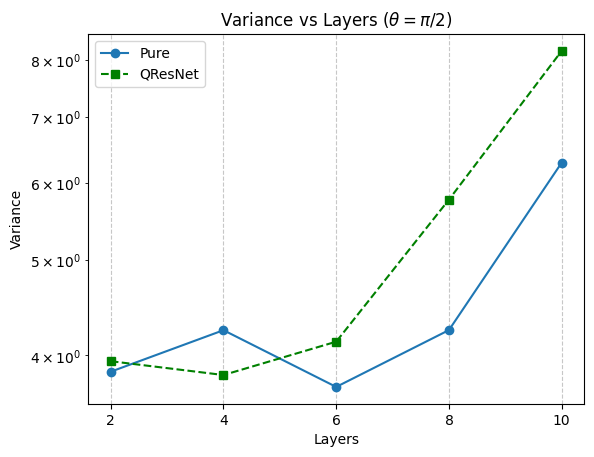

In [10]:
plt.plot(n_qubits, var1, marker='o', label='Pure')
#plt.plot(n_qubits, var2, marker='^', label='Lower bound')
plt.semilogy(n_qubits, var0, marker='s', label='QResNet', linestyle='--', color='green')
plt.xlabel('Layers')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.7)
plt.xticks(n_qubits)
plt.ylabel('Variance')
plt.title(r'Variance vs Layers ($\theta=\pi/2$)')
plt.legend()
plt.show()